# OpenAI VLM

In [56]:
# Import der benötigten Bibliotheken
import openai
from dotenv import load_dotenv  
import os # Ermöglicht den Zugriff auf Betriebssystemfunktionen,
import base64
import json
import textwrap

# Funktion zur Kodierung von Bildern in Base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Laden der Umgebungsvariablen (z.B. API-Schlüssel)
load_dotenv()

# Initialisiert den OpenAI-Client mit dem API-Schlüssel aus den Umgebungsvariablen
# Dies ermöglicht die Kommunikation mit GPT-4 oder anderen OpenAI-Modellen
openAIclient = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Modelle definieren
TEXTMODEL = "gpt-4o-mini"
IMGMODEL = "gpt-4o-mini"

# Beispielbild
img = "images/test.jpg"


In [57]:
# Basisaufruf an GPT-4 mit einem Text-Prompt und einem Bild

# Sendet eine Anfrage an das GPT-4-Modell mit Bild- und Textinformationen
completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",  # Das Modell, das für die Analyse verwendet wird
    messages=[
        {
            "role": "user",  # Definiert die Rolle (in diesem Fall der Benutzer, der die Anfrage stellt)
            "content": [  # Die Eingabeinhalte, die das Modell verarbeiten soll
                {"type": "text", "text": "What's in this image?"},  # Textprompt mit einer Frage
                {
                    "type": "image_url",  # Bild als Eingabetyp
                    "image_url": {  # Eingabebild in Base64-kodiertem Format
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",  # Kodiertes Bild wird hier eingebettet (pfad ist im oberen Codeteil)
                        # "detail": "low"  # (Optional) Kann genutzt werden, um Details oder Auflösung zu steuern
                    }
                },
            ],
        }
    ],
)

# Formatierung und Ausgabe der Modellantwort

# Konvertiert die erste Antwort aus den Modellantworten in eine String-Darstellung
response = str(completion.choices[0].message)

# Gibt die Antwort formatiert aus, um sie besser lesbar zu machen
print(textwrap.fill(response, width=120))  # Wrappt die Textausgabe auf eine Breite von 120 Zeichen


ChatCompletionMessage(content='The image depicts a bustling marketplace scene. There are vibrant stalls filled with
various fruits and vegetables, including pineapples, grapes, and apples, under colorful umbrellas. People are walking
around, engaging in trade, and some are riding bicycles. A dog sits on the ground in the foreground. The setting appears
to include historical architecture, with tall buildings and a traffic light in the background, creating a lively and
dynamic atmosphere.', role='assistant', function_call=None, tool_calls=None, refusal=None)


In [58]:
def promptLLM(prompt: str = None, sysprompt: str = None, image: str = None, wantJson: bool = False, returnDict: bool = False):
    
    # Initialisierung der Rückgabevariable
    returnValue = ""

    # Nachrichtenliste initialisieren; beginnt mit dem System-Prompt
    messages = [{"role": "system", "content": sysprompt}]

    # Standardmäßig wird das Textmodell verwendet
    modelToUse = TEXTMODEL

    # Benutzer-Prompt wird in die Nachrichtenliste hinzugefügt
    messages.append({"role": "user", "content": [{ 
        "type": "text",  # Typ der Nachricht: Text
        "text": prompt   # Inhalt der Nachricht
    }]})

    # Falls ein Bild übergeben wird, wird es hinzugefügt
    if image is not None:
        # Bild wird in Base64-Format eingebettet
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url": image }})
        # Modell wird auf das multimodale Modell umgestellt
        modelToUse = IMGMODEL

    # Wenn die Antwort als JSON-Objekt gewünscht wird
    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Gewähltes Modell
            response_format={ "type": "json_object" },  # JSON-Format erzwingen
            messages=messages,  # Nachrichtenliste
            temperature=0,  # Kontrolliert die Zufälligkeit der Antwort
        )
    else:
        # Standardmäßiger Aufruf für eine Textantwort
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Gewähltes Modell
            messages=messages,  # Nachrichtenliste
            temperature=0,  # Kontrolliert die Zufälligkeit der Antwort
        )

    # Extrahiert den Textinhalt der Antwort
    returnValue = returnValue.choices[0].message.content

    # Falls Rückgabe als Python-Dictionary gewünscht, wird die JSON-Antwort geparst
    if returnDict:
        return json.loads(returnValue)

    # Gibt die Antwort als Text oder unveränderten JSON-String zurück
    return returnValue

In [59]:
output = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [60]:
output

{'description': {'setting': {'location': 'A bustling market street',
   'time': 'Late afternoon or early evening',
   'atmosphere': 'Vibrant and lively'},
  'elements': {'market_stalls': {'types': 'Fruit and vegetable stalls',
    'items': ['Pineapples', 'Grapes', 'Apples', 'Oranges', 'Bananas'],
    'canopies': ['Red', 'Green']},
   'people': {'activities': ['Shopping', 'Walking', 'Bicycling'],
    'attire': ['Hats', 'Coats', 'Dresses'],
    'diversity': 'A mix of genders and ages'},
   'animals': {'type': 'Dog',
    'position': 'Sitting on the ground near the market stalls'},
   'architecture': {'style': 'Historical buildings with ornate details',
    'notable_features': ['Dome on a building',
     'Modern skyscraper in the background']},
   'traffic_signals': {'type': 'Traffic light', 'status': 'Red light visible'},
   'bicycles': {'presence': 'Several bicycles parked or in use'}},
  'lighting': {'quality': 'Soft, warm light',
   'shadows': 'Long shadows cast by the buildings and pe

In [61]:
# Überprüfe, welche Hauptschlüssel im Dictionary output existieren:
print(output.keys())

dict_keys(['description'])


In [62]:
# Finde die Unterstruktur von description heraus:
print(output["description"].keys())

dict_keys(['setting', 'elements', 'lighting'])


In [64]:
# Schlüssel innerhalb von elements untersuchen
print(output["description"]["elements"].keys())

dict_keys(['market_stalls', 'people', 'animals', 'architecture', 'traffic_signals', 'bicycles'])


In [65]:
# Zugriff auf die allgemeine Szene-Beschreibung:
scene_description = output["description"]["setting"]
print(scene_description)

{'location': 'A bustling market street', 'time': 'Late afternoon or early evening', 'atmosphere': 'Vibrant and lively'}


In [66]:
# Zugriff auf das "people"-Element in der JSON-Struktur
people_data = output["description"]["elements"]["people"]

# Anzahl der Aktivitäten, um Personen indirekt zu zählen
people_count = len(people_data["activities"])  # Zählt die Aktivitäten als Proxy für Personen
print(f"Anzahl der Personen (geschätzt basierend auf Aktivitäten): {people_count}")

Anzahl der Personen (geschätzt basierend auf Aktivitäten): 3


In [67]:
# Zugriff auf die Marktstände
market_data = output["description"]["elements"]["market_stalls"]

# Zähle die verschiedenen Arten von Ständen
market_types_count = len(market_data["types"].split(", "))  # Angenommen, "types" ist durch Kommas getrennt
print(f"Anzahl der Markttypen: {market_types_count}")


Anzahl der Markttypen: 1


In [68]:
# Zugriff auf die Früchte
fruits = output["description"]["elements"]["market_stalls"]["items"]

# Ausgabe der Liste der Früchte
print("Liste der verfügbaren Früchte:")
for fruit in fruits:
    print(f"- {fruit}")


Liste der verfügbaren Früchte:
- Pineapples
- Grapes
- Apples
- Oranges
- Bananas


In [69]:
# Zugriff auf die Überdachungsfarben
# Analysiere die Anzahl der verschiedenen Farben der Überdachungen (Canopies):
canopy_colors = output["description"]["elements"]["market_stalls"]["canopies"]

# Anzahl der Farben ausgeben
print(f"Anzahl der Überdachungsfarben: {len(canopy_colors)}")
print(f"Farben der Überdachungen: {', '.join(canopy_colors)}")


Anzahl der Überdachungsfarben: 2
Farben der Überdachungen: Red, Green


In [70]:
# Zugriff auf die Architektur
architecture = output["description"]["elements"]["architecture"]

# Ausgabe der Architekturdetails
print(f"Architekturstil: {architecture['style']}")
print("Bemerkenswerte Eigenschaften der Gebäude:")
for feature in architecture["notable_features"]:
    print(f"- {feature}")


Architekturstil: Historical buildings with ornate details
Bemerkenswerte Eigenschaften der Gebäude:
- Dome on a building
- Modern skyscraper in the background


In [71]:
# Zugriff auf Tierinformationen
animal_data = output["description"]["elements"]["animals"]

# Tierdetails ausgeben
print(f"Tiertyp: {animal_data['type']}")
print(f"Position des Tieres: {animal_data['position']}")


Tiertyp: Dog
Position des Tieres: Sitting on the ground near the market stalls


In [72]:
# Zugriff auf die Verkehrsampelinformationen
# Überprüfe, welcher Status bei der Verkehrsampel sichtbar ist:
traffic_signal = output["description"]["elements"]["traffic_signals"]

# Status der Ampel ausgeben
print(f"Typ der Verkehrsampel: {traffic_signal['type']}")
print(f"Aktuelle Ampelstatus: {traffic_signal['status']}")


Typ der Verkehrsampel: Traffic light
Aktuelle Ampelstatus: Red light visible


In [77]:
# Dominate Farben im Bild analyisieren - 
# Zugriff auf die Farbpalette
colors = output["description"]["lighting"]

# Anzahl und Liste der Farben ausgeben
print(f"Anzahl der dominanten Farben: {len(colors)}")
print("Dominante Farben:")
for color in colors:
    print(f"- {color}")


Anzahl der dominanten Farben: 2
Dominante Farben:
- quality
- shadows


In [78]:
# Zugriff auf Zeit und Atmosphäre
time = output["description"]["setting"]["time"]
atmosphere = output["description"]["setting"]["atmosphere"]

# Ausgabe
print(f"Zeitpunkt: {time}")
print(f"Atmosphäre: {atmosphere}")

Zeitpunkt: Late afternoon or early evening
Atmosphäre: Vibrant and lively


# JSON Schema for Controlled Structured Outputs

In [82]:
def promptLLM(prompt: str = None, sysprompt: str = None, image: str = None, wantJson: bool = False, returnDict: bool = False):
    """
    Rückgabewert: Die Antwort des Modells als Text (Standard) oder als Python-Dictionary (bei JSON).
    """
    returnValue = ""  # Initialisierung der Rückgabewert-Variable

    # Aufbau der Nachricht: System-Prompt (Hintergrundkontext für das Modell)
    messages = [{"role": "system", "content": sysprompt}]

    # Standardmäßig wird das Textmodell verwendet
    modelToUse = TEXTMODEL

    # Hinzufügen des Benutzer-Prompts zur Nachrichtenliste
    messages.append({"role": "user", "content": [{ 
        "type": "text",  # Typ der Nachricht: Text
        "text": prompt   # Inhalt des Prompts
    }]})

    # Falls ein Bild übergeben wird, füge es hinzu
    if image is not None:
        # Konvertiert das Bild in das Base64-Format für die Anfrage
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": {"url": image}})
        # Wechsel zum multimodalen Modell
        modelToUse = IMGMODEL

    # JSON-Schema verwenden, falls wantJson=True
    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Wählt das richtige Modell
            response_format={  # Definiert das JSON-Schema für die Antwort
                "type": "json_schema",
                "json_schema": {
                    "name": "img_extract",  # Name des Schemas
                    "schema": {
                        "type": "object",  # JSON-Objekt
                        "properties": {  # Erwartete Felder in der Antwort
                            "numberOfPeople": {  # Anzahl der Personen
                                "type": "integer",
                                "description": "The total number of people in the environment",
                                "minimum": 0
                            },
                            "atmosphere": {  # Beschreibung der Atmosphäre
                                "type": "string",
                                "description": "Description of the atmosphere, e.g., calm, lively, etc."
                            },
                            "hourOfTheDay": {  # Uhrzeit
                                "type": "integer",
                                "description": "The hour of the day in 24-hour format",
                                "minimum": 0,
                                "maximum": 23
                            },
                            "people": {  # Liste mit Details zu Personen
                                "type": "array",
                                "description": "List of people and their details",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "position": {  # Position der Person
                                            "type": "string",
                                            "description": "Position of the person in the environment, e.g., standing, sitting, etc."
                                        },
                                        "age": {  # Alter der Person
                                            "type": "integer",
                                            "description": "Age of the person",
                                            "minimum": 0
                                        },
                                        "activity": {  # Aktivität der Person
                                            "type": "string",
                                            "description": "Activity the person is engaged in, e.g., reading, talking, etc."
                                        },
                                        "gender": {  # Geschlecht der Person
                                            "type": "string",
                                            "description": "Gender of the person",
                                            "enum": ["male", "female", "non-binary", "other", "prefer not to say"]
                                        }
                                    },
                                    "required": ["position", "age", "activity", "gender"]
                                }
                            }
                        },
                        "required": ["numberOfPeople", "atmosphere", "hourOfTheDay", "people"]
                    }
                }
            },
            messages=messages,  # Hinzugefügte Nachrichten
            temperature=0,  # Steuerung der Zufälligkeit der Antwort
        )
    else:
        # Standardmäßige Textantwort ohne JSON-Schema
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Modell wählen
            messages=messages,  # Hinzugefügte Nachrichten
            temperature=0,  # Steuerung der Zufälligkeit der Antwort
        )

    # Extrahiert die Antwort aus den Rückgabedaten
    returnValue = returnValue.choices[0].message.content

    # Falls JSON gewünscht ist, wird die Antwort als Python-Dictionary zurückgegeben
    if returnDict:
        return json.loads(returnValue)

    # Gibt die Antwort als Text zurück
    return returnValue


In [83]:
output_image_analysis = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [84]:
# Definiert den System-Prompt für die Rolle des Modells
alert_sys_prompt = "You are an experienced safety and emergency observer in crowded environments."

# Benutzer-Prompt, der eine Aufgabe formuliert
alert_prompt = """
Analyze the given scene, provided to you in JSON format, and identify potential safety risks or emergencies. 
Specifically, check if:
1. There are injured or unwell people visible in the image.
2. If any person (e.g., a child, elderly individual) might require medical assistance or help.
3. If emergency services like an ambulance should be alerted.
Provide a concise answer specifying the detected issue (if any) and recommend whether action is required. 
The situation is given to you from this object: """ + str(output_image_analysis)

# Erklärung:
# - Analysiert die JSON-Daten (aus `output_image_analysis`).
# - Entscheidet, ob es Personen gibt, die medizinische Hilfe benötigen könnten.
# - Gibt an, ob ein Krankenwagen oder andere Notdienste alarmiert werden sollten.


In [85]:
promptLLM(prompt = alert_prompt, sysprompt= alert_sys_prompt) 

'Based on the provided scene analysis, here are the findings:\n\n1. **Injured or Unwell People**: There are no indications of injured or unwell individuals visible in the image.\n2. **Individuals Requiring Assistance**: The only individual who might require assistance is the 5-year-old child who is playing. While there is no explicit indication of distress, young children can sometimes need supervision or help, especially in crowded environments.\n3. **Emergency Services**: There is no immediate need to alert emergency services like an ambulance, as there are no visible injuries or medical emergencies.\n\n**Recommendation**: While there is no urgent action required, it would be prudent to ensure that the child is being supervised and is safe in the lively environment.'

In [86]:
promptLLM(prompt = "Considering the image analysis given" +str(output_image_analysis)+ "give me back the coordinates of the dog. If these are not available, infer them form the pic", sysprompt= alert_sys_prompt) 

"Based on the provided information, there is a person sitting and watching a dog, but specific coordinates for the dog are not given. Since the dog is being observed by a person, we can infer that the dog is likely nearby that individual.\n\nTo estimate the coordinates of the dog, we can assume the following:\n\n1. The person watching the dog is sitting at a certain position.\n2. The dog is likely within a few feet of that person, possibly in front of or beside them.\n\nIf we assume the sitting person (age 45, male) is positioned at coordinates (x, y), we can estimate the dog's coordinates to be around (x ± 1, y ± 1) depending on the layout of the area.\n\nHowever, without specific coordinates or a visual reference, we cannot provide exact coordinates for the dog. If you have a specific coordinate system or layout in mind, please provide that for a more accurate estimation."

In [87]:
promptLLM(prompt =  "Detect if there is a dog on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.", sysprompt= alert_sys_prompt, image = encode_image(img)) 

'[500, 600, 700, 800]'

# 2. Google VLM (Gemini)

In [88]:
%matplotlib inline
import os
from dotenv import load_dotenv  
import google.generativeai as genai
from PIL import Image

load_dotenv()
#genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [89]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain why 42 is important")
print(response.text)

The number 42's importance is almost entirely derived from its appearance in Douglas Adams's comedic science fiction book *The Hitchhiker's Guide to the Galaxy*.  In the story, 42 is revealed to be the "Answer to the Ultimate Question of Life, the Universe, and Everything," calculated by a supercomputer named Deep Thought over millions of years.

The crucial point is that **Adams never actually revealed the Ultimate Question**. This makes 42 inherently meaningless in any objective, mathematical, or scientific sense.  Its significance is entirely a matter of cultural reference and in-joke.  People find it humorous and intriguing precisely because of this inherent lack of a concrete meaning coupled with its grand, pronounceable declaration.

So, 42 isn't inherently important; its importance is entirely *constructed* and dependent on the context of the *Hitchhiker's Guide to the Galaxy*.  It's a memorable and widely recognized example of a cultural meme.



In [90]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a brown dog on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[733,602,937,822]


In [92]:
from PIL import Image  # Für Bildverarbeitung
import matplotlib.pyplot as plt  # Für Visualisierung
import matplotlib.patheffects as pe  # Für Text-Effekte bei Annotationen
from transformers import pipeline  # Für OWL-ViT

def compare_detections(image_path):
    # 1. Bild laden
    image = Image.open(image_path)  # Öffnet das Bild, das analysiert werden soll

    # 2. OWL-ViT Detektion
    def preprocess_outputs(output):
        """
        Verarbeitet die Ausgaben von OWL-ViT, um sie für die Visualisierung vorzubereiten.
        """
        input_scores = [x["score"] for x in output]  # Extrahiert die Detektions-Scores
        input_labels = [x["label"] for x in output]  # Extrahiert die Labels
        input_boxes = []
        for i in range(len(output)):
            input_boxes.append([*output[i]["box"].values()])  # Extrahiert die Koordinaten
        input_boxes = [input_boxes]
        return input_scores, input_labels, input_boxes

    def show_box(box, ax):
        """
        Zeichnet eine Bounding-Box auf das Bild.
        """
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(
            plt.Rectangle((x0, y0), w, h, edgecolor="red", facecolor="none", lw=3)
        )

    def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores, title):
        """
        Visualisiert Bounding-Boxen, Labels und Scores auf dem Bild.
        """
        plt.figure(figsize=(15, 15))
        plt.imshow(raw_image)
        for i, box in enumerate(boxes):
            show_box(box, plt.gca())  # Zeichnet Bounding-Box
            plt.text(
                x=box[0],
                y=box[1] - 12,
                s=f"{labels[i]}: {scores[i]:,.4f}",  # Label und Score anzeigen
                c="white",
                path_effects=[pe.withStroke(linewidth=4, foreground="red")],
                fontsize=12
            )
        plt.axis("on")
        plt.title(title, fontsize=14)
        plt.savefig(f'detected_objects_{title}.png', bbox_inches='tight', dpi=300)
        plt.close()

    # OWL-ViT Setup mit angepassten Labels
    OWL_checkpoint = "google/owlvit-base-patch32"  # Modell-Checkpoint
    text = [
        "a dog sitting near the market stalls",  # Ein Hund in der Nähe von Marktständen
        "a person shopping",  # Eine Person beim Einkaufen
        "a person riding a bicycle",  # Eine Person auf einem Fahrrad
        "fruit stalls with colorful fruits",  # Obststände mit bunten Früchten
        "historic buildings",  # Historische Gebäude
        "a traffic light",  # Eine Verkehrsampel
    ]

    # OWL-ViT Modell initialisieren
    detector = pipeline(
        model=OWL_checkpoint,
        task="zero-shot-object-detection"
    )

    # OWL-ViT Detektion ausführen
    output_owl = detector(
        image,  # Eingabebild
        candidate_labels=text,  # Textlabels für die Detektion
        threshold=0.1  # Score-Schwelle
    )

    print("\nOWL-ViT Detection Results:")
    print(output_owl)

    # Ergebnisse von OWL-ViT visualisieren
    input_scores, input_labels, input_boxes = preprocess_outputs(output_owl)
    show_boxes_and_labels_on_image(
        image, input_boxes[0], input_labels, input_scores, "OWL-ViT Detection"
    )

# Funktion für das Bild ausführen
image_path = "/workspaces/MultimodalInteraction_ObjDet/images/test.jpg"  # Pfad zum Bild
print(f"\nProcessing image: {image_path}")
compare_detections(image_path)



Processing image: /workspaces/MultimodalInteraction_ObjDet/images/test.jpg


/home/vscode/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



OWL-ViT Detection Results:
[{'score': 0.6770167350769043, 'label': 'a traffic light', 'box': {'xmin': 719, 'ymin': 167, 'xmax': 761, 'ymax': 267}}, {'score': 0.5344061851501465, 'label': 'a traffic light', 'box': {'xmin': 781, 'ymin': 332, 'xmax': 804, 'ymax': 381}}, {'score': 0.3828839063644409, 'label': 'a person riding a bicycle', 'box': {'xmin': 720, 'ymin': 562, 'xmax': 957, 'ymax': 716}}, {'score': 0.24031485617160797, 'label': 'fruit stalls with colorful fruits', 'box': {'xmin': 5, 'ymin': 328, 'xmax': 475, 'ymax': 939}}, {'score': 0.23653271794319153, 'label': 'a person riding a bicycle', 'box': {'xmin': 1, 'ymin': 656, 'xmax': 249, 'ymax': 961}}, {'score': 0.23599353432655334, 'label': 'fruit stalls with colorful fruits', 'box': {'xmin': 5, 'ymin': 547, 'xmax': 477, 'ymax': 804}}, {'score': 0.22048407793045044, 'label': 'a person shopping', 'box': {'xmin': 488, 'ymin': 469, 'xmax': 578, 'ymax': 724}}, {'score': 0.21874216198921204, 'label': 'a person shopping', 'box': {'xmin'

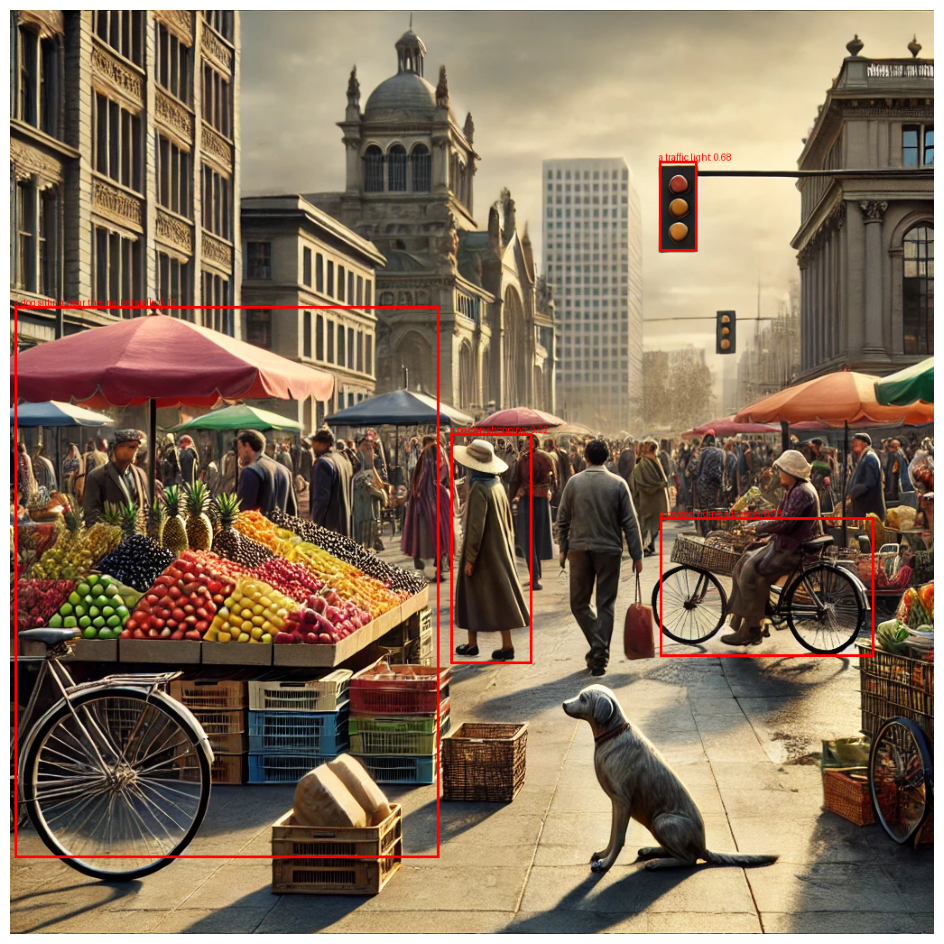

In [93]:
from PIL import Image, ImageDraw  # Für Bildverarbeitung und Zeichnen von Bounding-Boxen
import matplotlib.pyplot as plt  # Für die Anzeige des Bildes

def draw_detections(image_path, detections):
    """
    Zeichnet Bounding-Boxen basierend auf den Detektions-Ergebnissen auf das Bild.
    """
    # 1. Bild laden
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)  # Ermöglicht das Zeichnen auf dem Bild

    # 2. Durch die Erkennungen iterieren und Bounding-Boxen zeichnen
    for detection in detections:
        box = detection["box"]
        label = detection["label"]
        score = detection["score"]

        # Bounding-Box-Daten extrahieren
        xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]

        # Rechteck zeichnen
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red", width=3)

        # Label und Score anzeigen
        draw.text((xmin, ymin - 10), f"{label}: {score:.2f}", fill="red")

    # 3. Bild anzeigen
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Beispielhafte Detektions-Ergebnisse (aus deiner Ausgabe)
detections = [
    {"score": 0.677, "label": "a traffic light", "box": {"xmin": 719, "ymin": 167, "xmax": 761, "ymax": 267}},
    {"score": 0.382, "label": "a person riding a bicycle", "box": {"xmin": 720, "ymin": 562, "xmax": 957, "ymax": 716}},
    {"score": 0.220, "label": "a person shopping", "box": {"xmin": 488, "ymin": 469, "xmax": 578, "ymax": 724}},
    {"score": 0.124, "label": "a dog sitting near the market stalls", "box": {"xmin": 5, "ymin": 328, "xmax": 475, "ymax": 939}},
]

# Pfad zum Bild
image_path = "/workspaces/MultimodalInteraction_ObjDet/images/test.jpg"

# Funktion ausführen
draw_detections(image_path, detections)


THE END